# Next-Day Sales Prediction for Grocery Store

This notebook builds a machine learning model to predict next-day sales for each product.

**Dataset**: Grocery Chain Sales Data (1980+ transactions)

**Goal**: Help reduce stock issues by accurately forecasting daily sales per product

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load the dataset
df = pd.read_csv('grocery_chain_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (1980, 11)

Columns: ['customer_id', 'store_name', 'transaction_date', 'aisle', 'product_name', 'quantity', 'unit_price', 'total_amount', 'discount_amount', 'final_amount', 'loyalty_points']

First few rows:


,customer_id,store_name,transaction_date,aisle,product_name,quantity,unit_price,total_amount,discount_amount,final_amount,loyalty_points
0,2824,GreenGrocer Plaza,2023-08-26,Produce,Pasta,2.0,7.46,14.92,0.00,14.92,377
1,5506,ValuePlus Market,2024-02-13,Dairy,Cheese,1.0,1.85,1.85,3.41,-1.56,111
2,4657,ValuePlus Market,2023-11-23,Bakery,Onions,4.0,7.38,29.52,4.04,25.48,301
3,2679,SuperSave Central,2025-01-13,Snacks & Candy,Cereal,3.0,5.50,16.50,1.37,15.13,490
4,9935,GreenGrocer Plaza,2023-10-13,Canned Goods,Orange Juice,5.0,8.66,43.30,1.50,41.80,22
5,7912,Corner Grocery,2023-08-31,Dairy,Onions,3.0,25.04,75.12,1.77,73.35,316
6,1488,GreenGrocer Plaza,2023-10-18,Produce,Ground Beef,3.0,29.56,88.68,2.52,86.16,437
7,4582,City Fresh Store,2024-02-03,Health & Wellness,Orange Juice,2.0,11.73,23.46,0.00,23.46,107
8,9279,GreenGrocer Plaza,2024-11-16,Household Items,Apples,5.0,22.13,110.65,11.07,99.58,83
9,1434,QuickStop Market,2024-10-15,Health & Wellness,Onions,2.0,20.84,41.68,8.34,33.34,431


## 2. Data Exploration

In [3]:
# Dataset overview
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)
print(f"\nShape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nBasic Statistics:")
df.describe()

DATASET INFORMATION

Shape: 1980 rows, 11 columns

Data Types:
customer_id           int64
store_name           object
transaction_date     object
aisle                object
product_name         object
quantity            float64
unit_price          float64
total_amount        float64
discount_amount     float64
final_amount        float64
loyalty_points        int64
dtype: object

Missing Values:
customer_id          0
store_name          25
transaction_date     0
aisle                0
product_name         0
quantity             0
unit_price           0
total_amount         0
discount_amount      0
final_amount         0
loyalty_points       0
dtype: int64

Basic Statistics:


,customer_id,quantity,unit_price,total_amount,discount_amount,final_amount,loyalty_points
count,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000,1980.000000
mean,5542.958081,2.968182,15.488045,45.902576,4.469591,41.432985,255.147980
std,2575.771856,1.419028,8.400823,35.018599,4.962001,32.593328,146.009333
min,1006.000000,1.000000,0.990000,1.010000,0.000000,-3.430000,0.000000
25%,3271.500000,2.000000,8.240000,18.000000,1.240000,15.800000,128.000000
50%,5582.500000,3.000000,15.190000,37.130000,3.045000,32.820000,265.500000
75%,7791.750000,4.000000,22.862500,67.930000,5.402500,60.800000,378.000000
max,9998.000000,5.000000,29.980000,149.900000,29.940000,147.910000,500.000000


In [4]:
# Convert transaction_date to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

print(f"Date range: {df['transaction_date'].min()} to {df['transaction_date'].max()}")
print(f"Total days: {(df['transaction_date'].max() - df['transaction_date'].min()).days} days")
print(f"\nUnique stores: {df['store_name'].nunique()}")
print(f"Unique products: {df['product_name'].nunique()}")
print(f"Unique aisles: {df['aisle'].nunique()}")

Date range: 2023-08-07 00:00:00 to 2025-08-05 00:00:00
Total days: 729 days

Unique stores: 9
Unique products: 18
Unique aisles: 11


In [5]:
# Aggregate to daily sales per product
# This is key: we need daily totals per product
daily_sales = df.groupby(['transaction_date', 'product_name', 'store_name']).agg({
    'quantity': 'sum',
    'final_amount': 'sum',
    'aisle': 'first'  # Product aisle
}).reset_index()

print(f"Aggregated daily sales shape: {daily_sales.shape}")
print(f"\nSample of aggregated data:")
daily_sales.head(10)

Aggregated daily sales shape: (1938, 6)

Sample of aggregated data:


,transaction_date,product_name,store_name,quantity,final_amount,aisle
0,2023-08-07,Carrots,City Fresh Store,1.0,28.26,Beverages
1,2023-08-07,Pasta,ValuePlus Market,1.0,12.26,Meat & Seafood
2,2023-08-08,Cheese,Corner Grocery,5.0,117.30,Bakery
3,2023-08-08,Onions,FreshMart Downtown,5.0,48.20,Dairy
4,2023-08-08,Orange Juice,MegaMart Westside,4.0,39.88,Beverages
5,2023-08-08,Yogurt,FamilyFood Express,1.0,23.19,Meat & Seafood
6,2023-08-11,Chicken Breast,GreenGrocer Plaza,3.0,31.58,Bakery
7,2023-08-11,Eggs,ValuePlus Market,3.0,64.41,Beverages
8,2023-08-12,Bananas,ValuePlus Market,3.0,34.21,Beverages
9,2023-08-12,Bread,Corner Grocery,5.0,34.43,Snacks & Candy


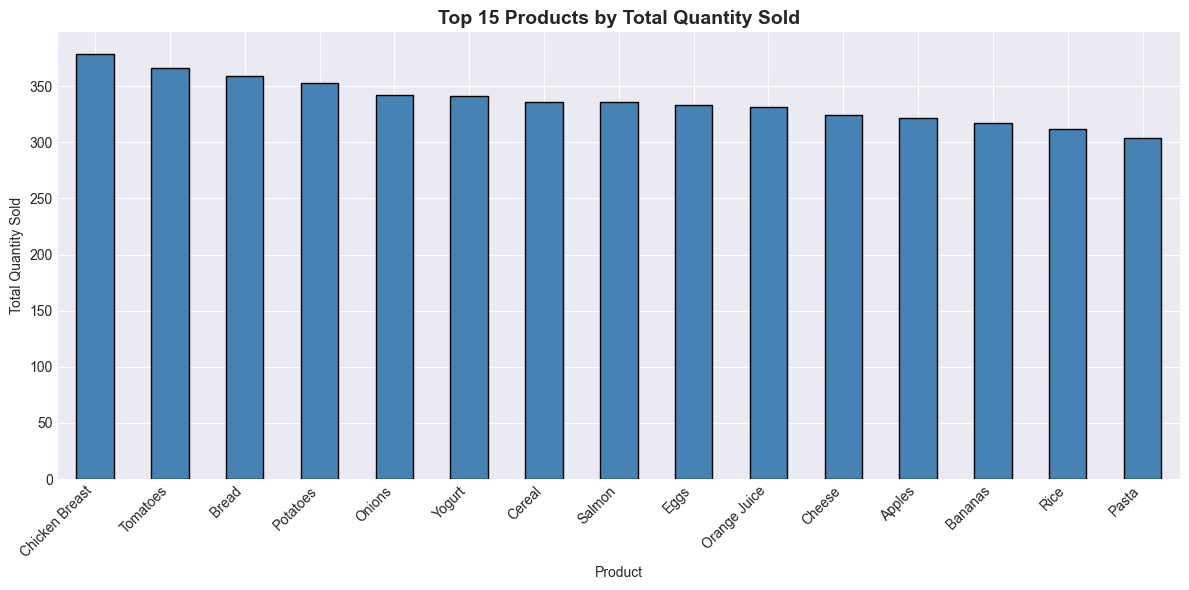


Top 15 Products:
product_name
Chicken Breast    379.0
Tomatoes          366.0
Bread             359.0
Potatoes          353.0
Onions            342.0
Yogurt            341.0
Cereal            336.0
Salmon            336.0
Eggs              333.0
Orange Juice      331.0
Cheese            324.0
Apples            322.0
Bananas           317.0
Rice              312.0
Pasta             304.0
Name: quantity, dtype: float64


In [6]:
# Visualize top products
top_products = df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
top_products.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Top 15 Products by Total Quantity Sold', fontsize=14, fontweight='bold')
plt.xlabel('Product')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nTop 15 Products:")
print(top_products)

## 3. Feature Engineering for Time Series

In [7]:
# Sort by product, store, and date
df_features = daily_sales.sort_values(['product_name', 'store_name', 'transaction_date']).reset_index(drop=True)

# Extract temporal features
df_features['year'] = df_features['transaction_date'].dt.year
df_features['month'] = df_features['transaction_date'].dt.month
df_features['day'] = df_features['transaction_date'].dt.day
df_features['day_of_week'] = df_features['transaction_date'].dt.dayofweek
df_features['day_of_year'] = df_features['transaction_date'].dt.dayofyear
df_features['week_of_year'] = df_features['transaction_date'].dt.isocalendar().week
df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
df_features['is_month_start'] = df_features['transaction_date'].dt.is_month_start.astype(int)
df_features['is_month_end'] = df_features['transaction_date'].dt.is_month_end.astype(int)

print("✓ Temporal features created")

✓ Temporal features created


In [8]:
# Create lag features - previous days' sales
# Group by product AND store for accurate lags
for lag in [1, 2, 3, 7]:
    df_features[f'sales_lag_{lag}'] = df_features.groupby(['product_name', 'store_name'])['quantity'].shift(lag)

# Rolling statistics (using shift to avoid data leakage)
for window in [3, 7, 14]:
    df_features[f'sales_rolling_mean_{window}'] = df_features.groupby(['product_name', 'store_name'])['quantity'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    df_features[f'sales_rolling_std_{window}'] = df_features.groupby(['product_name', 'store_name'])['quantity'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    )

# Exponential weighted moving average
df_features['sales_ewm_7'] = df_features.groupby(['product_name', 'store_name'])['quantity'].transform(
    lambda x: x.shift(1).ewm(span=7, adjust=False).mean()
)

print("✓ Lag and rolling features created")

✓ Lag and rolling features created


In [9]:
# Encode categorical variables
le_product = LabelEncoder()
le_store = LabelEncoder()
le_aisle = LabelEncoder()

df_features['product_encoded'] = le_product.fit_transform(df_features['product_name'])
df_features['store_encoded'] = le_store.fit_transform(df_features['store_name'])
df_features['aisle_encoded'] = le_aisle.fit_transform(df_features['aisle'])

print("✓ Categorical variables encoded")
print(f"  - Products: {len(le_product.classes_)}")
print(f"  - Stores: {len(le_store.classes_)}")
print(f"  - Aisles: {len(le_aisle.classes_)}")

✓ Categorical variables encoded
  - Products: 18
  - Stores: 9
  - Aisles: 11


In [10]:
# Check missing values
print("Missing values after feature engineering:")
missing = df_features.isnull().sum()
print(missing[missing > 0])

# Fill remaining NaN with 0 (for rolling std and first few days)
df_features = df_features.fillna(0)

print("\n✓ Missing values handled")

Missing values after feature engineering:
sales_lag_1               162
sales_lag_2               324
sales_lag_3               486
sales_lag_7              1124
sales_rolling_mean_3      162
sales_rolling_std_3       324
sales_rolling_mean_7      162
sales_rolling_std_7       324
sales_rolling_mean_14     162
sales_rolling_std_14      324
sales_ewm_7               162
dtype: int64

✓ Missing values handled


## 4. Prepare Data for Modeling

In [11]:
# Remove rows where we don't have lag_1 (can't predict without yesterday's data)
# Keep only rows where sales_lag_1 was actually recorded (not filled with 0)
df_model = df_features[df_features.groupby(['product_name', 'store_name']).cumcount() >= 1].copy()

print(f"Dataset shape for modeling: {df_model.shape}")
print(f"Removed {df_features.shape[0] - df_model.shape[0]} rows (first day per product-store)")

Dataset shape for modeling: (1776, 29)
Removed 162 rows (first day per product-store)


In [12]:
# Define features and target
exclude_cols = ['transaction_date', 'product_name', 'store_name', 'aisle', 'quantity', 'final_amount']

feature_cols = [col for col in df_model.columns if col not in exclude_cols]

X = df_model[feature_cols]
y = df_model['quantity']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used ({len(feature_cols)} total):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Features shape: (1776, 23)
Target shape: (1776,)

Features used (23 total):
   1. year
   2. month
   3. day
   4. day_of_week
   5. day_of_year
   6. week_of_year
   7. is_weekend
   8. is_month_start
   9. is_month_end
  10. sales_lag_1
  11. sales_lag_2
  12. sales_lag_3
  13. sales_lag_7
  14. sales_rolling_mean_3
  15. sales_rolling_std_3
  16. sales_rolling_mean_7
  17. sales_rolling_std_7
  18. sales_rolling_mean_14
  19. sales_rolling_std_14
  20. sales_ewm_7
  21. product_encoded
  22. store_encoded
  23. aisle_encoded


In [13]:
# Check for any remaining NaN or inf values
print("Checking data quality...")
print(f"NaN in X: {X.isnull().sum().sum()}")
print(f"NaN in y: {y.isnull().sum()}")
print(f"Inf in X: {np.isinf(X.values).sum()}")
print(f"Inf in y: {np.isinf(y.values).sum()}")

# Replace any remaining inf with 0
X = X.replace([np.inf, -np.inf], 0)
y = y.replace([np.inf, -np.inf], 0)

print("\n✓ Data quality check complete")

Checking data quality...
NaN in X: 0
NaN in y: 0


TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Time-based split (80% train, 20% test)
split_index = int(len(df_model) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

train_dates = df_model['transaction_date'].iloc[:split_index]
test_dates = df_model['transaction_date'].iloc[split_index:]
print(f"\nTraining period: {train_dates.min()} to {train_dates.max()}")
print(f"Testing period: {test_dates.min()} to {test_dates.max()}")

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled")

## 5. Model Training and Evaluation

In [ ]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Avoid division by zero in MAPE
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else 0
    
    print(f"\n{'='*60}")
    print(f"{model_name} Performance")
    print(f"{'='*60}")
    print(f"Mean Absolute Error (MAE):      {mae:.2f} units")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} units")
    print(f"R² Score:                       {r2:.4f}")
    print(f"Mean Absolute % Error (MAPE):   {mape:.2f}%")
    
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

In [ ]:
# Train models
results = []

print("Training models...\n")

# 1. Linear Regression
print("[1/4] Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = np.maximum(lr_model.predict(X_test_scaled), 0)
results.append(evaluate_model(y_test, lr_pred, "Linear Regression"))

# 2. Ridge Regression
print("\n[2/4] Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = np.maximum(ridge_model.predict(X_test_scaled), 0)
results.append(evaluate_model(y_test, ridge_pred, "Ridge Regression"))

# 3. Random Forest
print("\n[3/4] Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5, 
                                 random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = np.maximum(rf_model.predict(X_test), 0)
results.append(evaluate_model(y_test, rf_pred, "Random Forest"))

# 4. Gradient Boosting
print("\n[4/4] Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                     random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = np.maximum(gb_model.predict(X_test), 0)
results.append(evaluate_model(y_test, gb_pred, "Gradient Boosting"))

print("\n✓ All models trained!")

In [ ]:
# Compare models
results_df = pd.DataFrame(results).sort_values('MAE')

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print(f"\n✓ Best model: {results_df.iloc[0]['model']}")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    colors = ['green' if x == results_df[metric].max() else 'steelblue' for x in results_df[metric]] if metric == 'R2' else ['green' if x == results_df[metric].min() else 'steelblue' for x in results_df[metric]]
    ax.barh(results_df['model'], results_df[metric], color=colors, edgecolor='black')
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature Importance

In [ ]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15))

plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='teal', edgecolor='black')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score', fontweight='bold')
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Prediction Visualization

In [ ]:
# Use best model predictions (Random Forest)
best_pred = rf_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Actual vs Predicted
axes[0].scatter(y_test, best_pred, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Sales', fontweight='bold')
axes[0].set_ylabel('Predicted Sales', fontweight='bold')
axes[0].set_title('Actual vs Predicted Sales', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residuals
residuals = y_test - best_pred
axes[1].scatter(best_pred, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Sales', fontweight='bold')
axes[1].set_ylabel('Residuals', fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Time series for top product
test_df = df_model.iloc[split_index:].copy()
test_df['predictions'] = best_pred

# Select top product
top_product = test_df.groupby('product_name')['quantity'].sum().idxmax()
product_data = test_df[test_df['product_name'] == top_product].head(30)

if len(product_data) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(product_data['transaction_date'], product_data['quantity'], 
             marker='o', label='Actual', linewidth=2)
    plt.plot(product_data['transaction_date'], product_data['predictions'], 
             marker='s', label='Predicted', linewidth=2, alpha=0.7)
    plt.xlabel('Date', fontweight='bold')
    plt.ylabel('Quantity Sold', fontweight='bold')
    plt.title(f'Prediction Example: {top_product}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 8. Business Insights

In [ ]:
# Add predictions to test data
test_df['error'] = np.abs(test_df['quantity'] - test_df['predictions'])
test_df['error_pct'] = (test_df['error'] / test_df['quantity'].replace(0, 1)) * 100

# Accuracy by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_analysis = test_df.groupby('day_of_week').agg({
    'error': 'mean',
    'quantity': 'mean'
}).round(2)
dow_analysis.index = [day_names[i] for i in dow_analysis.index]

print("Prediction Accuracy by Day of Week:")
print(dow_analysis)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
dow_analysis['error'].plot(kind='bar', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_title('Avg Prediction Error by Day', fontweight='bold')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('MAE')

dow_analysis['quantity'].plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Avg Sales by Day', fontweight='bold')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Quantity')

plt.tight_layout()
plt.show()

In [ ]:
# Product accuracy ranking
product_accuracy = test_df.groupby('product_name').agg({
    'error': 'mean',
    'quantity': ['mean', 'count']
}).round(2)
product_accuracy.columns = ['MAE', 'Avg_Sales', 'Count']
product_accuracy = product_accuracy[product_accuracy['Count'] >= 3]

print("\nTop 5 Most Accurately Predicted Products:")
print(product_accuracy.nsmallest(5, 'MAE'))

print("\nTop 5 Least Accurately Predicted Products:")
print(product_accuracy.nlargest(5, 'MAE'))

## 9. Save Model

In [ ]:
import pickle

# Save model and all necessary components
model_artifacts = {
    'model': rf_model,
    'scaler': scaler,
    'feature_columns': feature_cols,
    'product_encoder': le_product,
    'store_encoder': le_store,
    'aisle_encoder': le_aisle,
    'metrics': results_df.iloc[0].to_dict(),
    'feature_importance': feature_importance
}

with open('sales_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✓ Model saved as 'sales_prediction_model.pkl'")
print(f"\nBest Model: {results_df.iloc[0]['model']}")
print(f"MAE: {results_df.iloc[0]['MAE']:.2f} units")
print(f"R² Score: {results_df.iloc[0]['R2']:.4f}")

## 10. Summary

In [ ]:
print("="*70)
print("SALES PREDICTION MODEL - SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   - Total records: {len(df_model):,}")
print(f"   - Products: {df_model['product_name'].nunique()}")
print(f"   - Stores: {df_model['store_name'].nunique()}")
print(f"   - Date range: {df_model['transaction_date'].min()} to {df_model['transaction_date'].max()}")

print(f"\n🎯 Best Model: {results_df.iloc[0]['model']}")
print(f"   - MAE: {results_df.iloc[0]['MAE']:.2f} units")
print(f"   - RMSE: {results_df.iloc[0]['RMSE']:.2f} units")
print(f"   - R² Score: {results_df.iloc[0]['R2']:.4f}")
print(f"   - MAPE: {results_df.iloc[0]['MAPE']:.2f}%")

print(f"\n💡 Top 3 Most Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n🚀 Next Steps:")
print(f"   1. Use terminal script for predictions")
print(f"   2. Monitor accuracy weekly")
print(f"   3. Retrain monthly with new data")
print(f"   4. Integrate with inventory system")

print("\n" + "="*70)